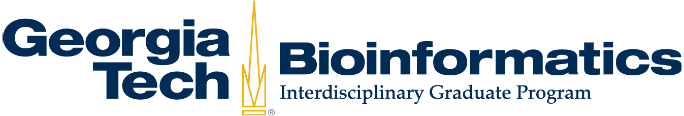

<div class="alert alert-block alert-info">
    <h1>BIOS 4150/BIOL 6150</h1>
    <h3>Instructor: Dr. King Jordan</h3>
    <p>Shivam Sharma (shivamsharma13@gatech.edu), Nilavrah Sensarma (nsensarma3@gatech.edu), Bengy Gyimah-Asamoah, (bgyimaha3@gatech.edu)

</p>
</div>

<div class="alert alert-block alert-warning">
    <h2>Project 8 (Pharmacogenomics) starter notebook</h2>
    <h3>Deadline: 11:59PM, November 18th, 2024</h3>
</div>

<div class="alert alert-block alert-danger">
    <h2>Alert!</h2>
    <p>Do not delete any comments or information boxes the starter notebook comes with</p>
</div>

---

# **1. Knowing your data**
### *Total Questions: 3*
### *Total Points: 5+5+20 = 30*


---

<div class="alert alert-block alert-warning">
    <h3>1.1 Download the information file</h3>
    <p>For this project, you will need to access PharmGKB annotated variants. PharmGKB has multiple resources, but we will focus on the clinical variant data file. This file should have variant-drug pairs and level of evidence for all clinical annotations.</p>
    <p>Download the file and show top 5 lines of the file</p>
</div>

In [3]:
#Show the file here.
import pandas as pd

# Load the data
file_path = '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/clinicalVariants.tsv' 
clinical_variants = pd.read_csv(file_path, sep='\t')

# Display the top 5 rows
print(clinical_variants.head())

print(clinical_variants[['variant', 'gene', 'type', 'level of evidence', 'chemicals', 'phenotypes']].head())



                                   variant    gene           type  \
0  CYP2C9*1, CYP2C9*2, CYP2C9*3, CYP2C9*13  CYP2C9  Metabolism/PK   
1            CYP2C9*1, CYP2C9*3, CYP2C9*13  CYP2C9  Metabolism/PK   
2             CYP2C9*1, CYP2C9*2, CYP2C9*3  CYP2C9  Metabolism/PK   
3                               rs17376848    DPYD       Toxicity   
4                                rs2297595    DPYD       Toxicity   

  level of evidence     chemicals phenotypes  
0                1A     meloxicam        NaN  
1                1A    lornoxicam        NaN  
2                1A     siponimod        NaN  
3                1A  capecitabine  Neoplasms  
4                1A  capecitabine  Neoplasms  
                                   variant    gene           type  \
0  CYP2C9*1, CYP2C9*2, CYP2C9*3, CYP2C9*13  CYP2C9  Metabolism/PK   
1            CYP2C9*1, CYP2C9*3, CYP2C9*13  CYP2C9  Metabolism/PK   
2             CYP2C9*1, CYP2C9*2, CYP2C9*3  CYP2C9  Metabolism/PK   
3                          

<div class="alert alert-block alert-warning">
    <h3>1.2 Filter the file</h3>
    <p>Although star alleles can be processed, we will only focus on dbSNP annotated variants (those that have rs ids)</p>
    <p>Filter the file for dbSNP annotated variants and count them</p>
    
</div>

In [6]:
dbSNP_variants = clinical_variants[clinical_variants['variant'].str.startswith('rs')]

# Perform a line count 
dbSNP_count = len(dbSNP_variants)

# Display the line count and the first 5 rows of the filtered data
print(f"Number of dbSNP annotated variants (line count, similar to wc -l): {dbSNP_count}")
print(dbSNP_variants.head())

# Save the rs IDs to a text file (one ID per line)
dbSNP_variants['variant'].to_csv('dbsnp_rsids.txt', index=False, header=False)

unique_levels_count = clinical_variants['level of evidence'].nunique()
unique_levels = clinical_variants['level of evidence'].unique()

print(unique_levels_count)
print(unique_levels)


Number of dbSNP annotated variants (line count, similar to wc -l): 4575
      variant  gene      type level of evidence     chemicals phenotypes
3  rs17376848  DPYD  Toxicity                1A  capecitabine  Neoplasms
4   rs2297595  DPYD  Toxicity                1A  capecitabine  Neoplasms
5   rs1801265  DPYD  Toxicity                1A  capecitabine  Neoplasms
8   rs1801160  DPYD  Toxicity                1A  capecitabine  Neoplasms
9   rs1801159  DPYD  Toxicity                1A  capecitabine  Neoplasms
6
['1A' '1B' '2A' '2B' '3' '4']


<div class="alert alert-block alert-warning">
    <h3>1.3 Think ahead!</h3>
    <p><b>Eventual Goal:</b> Quantify the presence of the variants obtained in Question 1.2. We will extract these variants from the 1000 genomes VCF file.</p>
    <p>Use whatever resource you want to. The end goal is to have appropriate information about these variants obtained in 1.2.</p>
    <p>If you have to subset a VCF file (extract variants of interest), you will need information such as CHR, POS, etc. Although you can simply use the ID column to extract variants, that might not work everywhere.</p>
    <p>If you want to use R, please feel free to do so. Add screenshots from PACE-ICE RStudio here. Your R workflow would essentially output a nice tsv file which you use later to extract variants</p>
    
</div>

<div class="alert alert-block alert-danger">
    <h2>Alert!</h2>
    <p>We do not want you to use dbSNP IDs (rs ids) to extract variants from the 1000 genomes data. The 1000 genomes file we provided you has dbSNP IDs and a simple bcftools command will do the job. But most VCF files you will come across in your work will not have dbSNP IDs. Therefore, we expect you to find relevant information about the variants obtained in Question 1.2 before moving to section 2.</p>
</div>

In [42]:
import pysam
import pandas as pd
import glob
import os

# Load rsIDs from the dbsnp_rsids.txt file
rs_ids = pd.read_csv('dbsnp_rsids.txt', header=None, names=['rsID'])
rs_id_set = set(rs_ids['rsID'])  

# Directory paths
vcf_dir = '/home/hice1/imusayeva3/biol6150/Data/1000Genomes/'
output_dir = '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmacogenomics_vcfs/'
os.makedirs(output_dir, exist_ok=True)

# Pattern for VCF files by chromosome
vcf_files = glob.glob(vcf_dir + "phase3.chr*.GRCh38.GT.crossmap.vcf.gz")

# Process each VCF file for each chromosome
for vcf_path in vcf_files:
    chr_name = os.path.basename(vcf_path).split('.')[1]  
    output_vcf = os.path.join(output_dir, f'filtered_{chr_name}.GRCh38.GT.crossmap.vcf.gz')

    with pysam.VariantFile(vcf_path) as vcf_in:
        header = vcf_in.header
        with pysam.VariantFile(output_vcf, 'w', header=header) as vcf_out:
            for record in vcf_in:
                if record.id in rs_id_set:
                    vcf_out.write(record)

    print(f"Filtered variants for {chr_name} saved to {output_vcf}")


Filtered variants for chr10 saved to /home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmacogenomics_vcfs/filtered_chr10.GRCh38.GT.crossmap.vcf.gz
Filtered variants for chr11 saved to /home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmacogenomics_vcfs/filtered_chr11.GRCh38.GT.crossmap.vcf.gz
Filtered variants for chr12 saved to /home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmacogenomics_vcfs/filtered_chr12.GRCh38.GT.crossmap.vcf.gz
Filtered variants for chr13 saved to /home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmacogenomics_vcfs/filtered_chr13.GRCh38.GT.crossmap.vcf.gz
Filtered variants for chr14 saved to /home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmacogenomics_vcfs/filtered_chr14.GRCh38.GT.crossmap.vcf.gz
Filtered variants for chr15 saved to /home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmac

# **2. Extract data**
### *Total Questions: 2*
### *Total Points: 5+15=20*


---

<div class="alert alert-block alert-warning">
    <h3>2.1 Subset the VCF files</h3>
    <p>2.1.1 How many variants obtained in 1.2 were found in the 1000 genomes data?</p>
    <p>2.1.2 Subset the VCF files (all chromosomes) and write the number of Pharmacogenomic variants found in chromosome 2.</p>
</div>

## There are total 2542 variants in the 1000 genomes data
## There are 179 variants in chromosome2

![Assigned Individual](resim1.png)

# **3. Pharmacogenomic variant distribution in 1000 genomes populations**
### *Total Steps: 3*
### *Total Points:  25+5+20=50*


---

<div class="alert alert-block alert-warning">
    <h3>3.1 Distribution by populations</h3>
        <p>For the 26 populations present in the 1000 genomes data, show the distribution of pharmaocgenomic variant frequencies stratified by "level of evidence"</p><hr>
    <h4>Step 1 - Find variant frequencies for all pharmacogenomic variants within each population.</h4>
    <p>The end result of this step should be a TSV file which has <i>x rows and 26 + w columns</i>. x = number of pharmacogenomic variants found in 1000 genome VCF files. 26 columns represent each 1000 genome population. w will be additonal metadata about the pharmacogenomic variant such as CHR POS ID etc</p>
    <p>This is a good exercise to implement a nice bash or python based solution where you can streamline a lot of things.</p>
    <h4>Step 2 - Annotate variants by level of evidence</h4>
    <p>This should be easy, just annotate them in your code or create separate files.</p>
    <h4>Step 3 - Visualize using boxplots</h4>
    <p>Every level of evidence will have it's set of 26 box plots showing frequency distribution of all variants </p>
    <p>In the end you will have multiple box plot graphs like the one shown below. Each graph will correspond to a specific level of evidence as determined by PharmaGKB (1A, 1B, 2A, 2B, ... , etc)</p>
</div>

In [41]:
import os
import glob
import pandas as pd

# Load population info from kgp3_id_pop.tsv
kgp3 = pd.read_csv("kgp3_id_pop.tsv", sep='\t')
kgp3_dict = dict(zip(kgp3['id'], kgp3['pop']))

# Directory paths
input_dir = "/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_pharmacogenomics_vcfs"
output_dir = "/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_population_info"
os.makedirs(output_dir, exist_ok=True)

# Iterate over each VCF file
vcf_files = glob.glob(f"{input_dir}/*.vcf")
for vcf_file in vcf_files:
    output_file = os.path.join(output_dir, os.path.basename(vcf_file).replace(".vcf", "_with_population.vcf"))
    header_lines = []
    data_lines = []

    with open(vcf_file, "r") as f:
        for line in f:
            if line.startswith("#CHROM"):
                columns = line.strip().split("\t")
                fixed_columns = columns[:5]  
                sample_ids = columns[5:]  
                
                updated_sample_ids = [
                    f"{sample_id}_{kgp3_dict.get(sample_id, 'Unknown')}"
                    for sample_id in sample_ids if sample_id.startswith(("HG", "NA"))
                ]
                
                updated_header = fixed_columns + updated_sample_ids
                header_lines.append("\t".join(updated_header) + "\n")
            
            elif line.startswith("#"):
                header_lines.append(line)
            else:
                data_lines.append(line)

    # updated VCF file
    with open(output_file, "w") as f:
        f.writelines(header_lines)
        f.writelines(data_lines)

    print(f"Updated VCF file '{output_file}' saved.")


Updated VCF file '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_population_info/filtered_chr10.GRCh38.GT.crossmap_with_population.vcf' saved.
Updated VCF file '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_population_info/filtered_chr11.GRCh38.GT.crossmap_with_population.vcf' saved.
Updated VCF file '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_population_info/filtered_chr12.GRCh38.GT.crossmap_with_population.vcf' saved.
Updated VCF file '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_population_info/filtered_chr13.GRCh38.GT.crossmap_with_population.vcf' saved.
Updated VCF file '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_population_info/filtered_chr14.GRCh38.GT.crossmap_with_population.vcf' saved.
Updated VCF file '/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_v

In [64]:
import pandas as pd

# Load clinical variants data
clinical_variants = pd.read_csv("clinicalVariants.tsv", sep='\t')

# Filter for only dbSNP variants (those starting with "rs")
dbSNP_variants = clinical_variants[clinical_variants['variant'].str.startswith('rs')]

# Consolidate duplicates by joining values for each rsID
# Group by 'variant' and aggregate each column, joining multiple entries with commas
consolidated_variants = dbSNP_variants.groupby('variant').agg({
    'level of evidence': lambda x: ','.join(x.dropna().astype(str).unique()),
    'chemicals': lambda x: ','.join(x.dropna().astype(str).unique()),
    'phenotypes': lambda x: ','.join(x.dropna().astype(str).unique()),
    'type': lambda x: ','.join(x.dropna().astype(str).unique())
}).reset_index()

clinical_info_dict = consolidated_variants.set_index('variant').to_dict('index')

# Define input and output VCF files
input_vcf = "/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/combined_variants_with_population.vcf"
output_vcf = "/home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_combined_with_clinical_info.vcf"

# Read and write the VCF file with updated INFO fields
with open(input_vcf, "r") as vcf_in, open(output_vcf, "w") as vcf_out:
    for line in vcf_in:
        if line.startswith("#"):
            if line.startswith("##INFO=<ID=level_of_evidence") or line.startswith("##INFO=<ID=chemicals") or line.startswith("##INFO=<ID=phenotypes") or line.startswith("##INFO=<ID=type"):
                continue  
            if line.startswith("#CHROM"):
                vcf_out.write('##INFO=<ID=level_of_evidence,Number=1,Type=String,Description="Level of evidence">\n')
                vcf_out.write('##INFO=<ID=chemicals,Number=1,Type=String,Description="Chemicals">\n')
                vcf_out.write('##INFO=<ID=phenotypes,Number=1,Type=String,Description="Phenotypes">\n')
                vcf_out.write('##INFO=<ID=type,Number=1,Type=String,Description="Variant Type">\n')
            vcf_out.write(line)
        else:
            fields = line.strip().split("\t")
            rsid = fields[2]  
            if rsid in clinical_info_dict:
                clinical_info = clinical_info_dict[rsid]
                info_field = fields[7]  
                new_info = [
                    f"level_of_evidence={clinical_info['level of evidence']}",
                    f"chemicals={clinical_info['chemicals']}",
                    f"phenotypes={clinical_info['phenotypes']}",
                    f"type={clinical_info['type']}"
                ]
                fields[7] = info_field + ";" + ";".join(new_info)  

            vcf_out.write("\t".join(fields) + "\n")

print(f"Updated VCF file with clinical info saved as {output_vcf}")


Updated VCF file with clinical info saved as /home/hice1/imusayeva3/biol6150/ProjectSubmissions/Group6/Project8/filtered_variants_combined_with_clinical_info.vcf


In [51]:
import re
import pandas as pd

# Input VCF and output TSV file paths
vcf_file = "filtered_variants_combined_with_clinical_info.vcf"
output_file = "all_variants_with_populations.tsv"

# List of populations to extract
populations = ["GBR", "FIN", "CHS", "PUR", "CDX", "CLM", "IBS", "PEL", "PJL", "KHV", 
               "ACB", "GWD", "ESN", "BEB", "MSL", "STU", "ITU", "CEU", "YRI", "CHB", 
               "JPT", "LWK", "ASW", "MXL", "TSI", "GIH"]

# List to store variant data
variants_data = []

# Dictionary to map sample IDs to their populations
sample_to_population = {}

# Open and read the VCF file
with open(vcf_file, "r") as vcf:
    for line in vcf:
        if line.startswith("#CHROM"):
            columns = line.strip().split("\t")
            sample_headers = columns[9:]              
            for sample in sample_headers:
                match = re.search(r'_(\w{3})$', sample)
                if match:
                    pop_code = match.group(1)
                    if pop_code in populations:
                        sample_id = sample.split("_")[0]
                        sample_to_population[sample_id] = pop_code
            continue

        elif not line.startswith("#"):
            vcf_columns = line.strip().split("\t")
            chrom = vcf_columns[0]
            pos = vcf_columns[1]
            variant_id = vcf_columns[2]
            ref = vcf_columns[3]
            alt = vcf_columns[4]
            info_field = vcf_columns[7]
            level_of_evidence = re.search(r'level_of_evidence=([^;]+)', info_field).group(1) if re.search(r'level_of_evidence=([^;]+)', info_field) else ""
            chemicals = re.search(r'chemicals=([^;]+)', info_field).group(1) if re.search(r'chemicals=([^;]+)', info_field) else ""
            phenotypes = re.search(r'phenotypes=([^;]+)', info_field).group(1) if re.search(r'phenotypes=([^;]+)', info_field) else ""
            variant_type = re.search(r'type=([^;]+)', info_field).group(1) if re.search(r'type=([^;]+)', info_field) else ""

            variant_samples = {pop: [] for pop in populations}
            
            for i, genotype in enumerate(vcf_columns[9:]):
                sample_id = sample_headers[i].split("_")[0]
                pop_code = sample_to_population.get(sample_id, "Unknown")
                
                if genotype != "0|0" and pop_code in populations:  
                    variant_samples[pop_code].append(sample_id)

            variant_info = {
                "CHROM": chrom,
                "POS": pos,
                "ID": variant_id,
                "REF": ref,
                "ALT": alt,
                "level_of_evidence": level_of_evidence,
                "chemicals": chemicals,
                "phenotypes": phenotypes,
                "type": variant_type
            }

            for pop in populations:
                variant_info[pop] = ",".join(variant_samples[pop]) if variant_samples[pop] else ""

            variants_data.append(variant_info)

# Convert list of dictionaries to DataFrame and save as TSV
df = pd.DataFrame(variants_data)
df.to_csv(output_file, sep="\t", index=False)
print(f"All variants with population info saved to {output_file}.")


All variants with population info saved to all_variants_with_populations.tsv.


In [1]:
import pandas as pd
input_file = "all_variants_with_populations.tsv"
df = pd.read_csv(input_file, sep='\t')

if 'level_of_evidence' not in df.columns:
    raise ValueError("The 'level_of_evidence' column is missing from the input file.")
levels_of_evidence = df['level_of_evidence'].unique()
for level in levels_of_evidence:
    level_df = df[df['level_of_evidence'] == level]    
    output_file = f"variants_level_of_evidence_{level}.tsv"    
    level_df.to_csv(output_file, sep='\t', index=False)
    
    print(f"Variants with level of evidence '{level}' saved to {output_file}")


Variants with level of evidence '3' saved to variants_level_of_evidence_3.tsv
Variants with level of evidence '4' saved to variants_level_of_evidence_4.tsv
Variants with level of evidence '1A' saved to variants_level_of_evidence_1A.tsv
Variants with level of evidence '3,4' saved to variants_level_of_evidence_3,4.tsv
Variants with level of evidence '2B' saved to variants_level_of_evidence_2B.tsv
Variants with level of evidence '1A,2A,3,4' saved to variants_level_of_evidence_1A,2A,3,4.tsv
Variants with level of evidence '2B,3' saved to variants_level_of_evidence_2B,3.tsv
Variants with level of evidence '1A,3' saved to variants_level_of_evidence_1A,3.tsv
Variants with level of evidence '1B,3' saved to variants_level_of_evidence_1B,3.tsv
Variants with level of evidence '1B' saved to variants_level_of_evidence_1B.tsv
Variants with level of evidence '1B,2A,3' saved to variants_level_of_evidence_1B,2A,3.tsv
Variants with level of evidence '2A' saved to variants_level_of_evidence_2A.tsv
Varian

In [1]:
import os
import pandas as pd

# Load the data
input_file = "all_variants_with_populations.tsv"
df = pd.read_csv(input_file, sep='\t')

if 'level_of_evidence' not in df.columns:
    raise ValueError("The 'level_of_evidence' column is missing from the input file.")

# Create a new column for sorting, using the first component of 'level_of_evidence'
df['primary_evidence'] = df['level_of_evidence'].apply(lambda x: x.split(',')[0])

# Get unique primary levels of evidence and sort them
unique_primary_levels = sorted(df['primary_evidence'].unique())

# Create the output directory
output_dir = "variants_by_evidence_level"
os.makedirs(output_dir, exist_ok=True)

# Iterate over sorted primary levels of evidence and save filtered files
for primary_level in unique_primary_levels:
    level_df = df[df['primary_evidence'] == primary_level]    
    output_file = os.path.join(output_dir, f"variants_level_of_evidence_{primary_level}.tsv")    
    level_df.to_csv(output_file, sep='\t', index=False)
    
    print(f"Variants with primary level of evidence '{primary_level}' saved to {output_file}")



Variants with primary level of evidence '1A' saved to variants_by_evidence_level/variants_level_of_evidence_1A.tsv
Variants with primary level of evidence '1B' saved to variants_by_evidence_level/variants_level_of_evidence_1B.tsv
Variants with primary level of evidence '2A' saved to variants_by_evidence_level/variants_level_of_evidence_2A.tsv
Variants with primary level of evidence '2B' saved to variants_by_evidence_level/variants_level_of_evidence_2B.tsv
Variants with primary level of evidence '3' saved to variants_by_evidence_level/variants_level_of_evidence_3.tsv
Variants with primary level of evidence '4' saved to variants_by_evidence_level/variants_level_of_evidence_4.tsv


In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Define input and output directories
input_dir = "variants_by_evidence_level"
output_dir = "boxplots_by_evidence_level"
os.makedirs(output_dir, exist_ok=True)

# Define a color palette 
palette = sns.color_palette("husl", n_colors=20)  

# Iterate over all .tsv files in the input directory
for i, file_name in enumerate(os.listdir(input_dir)):
    if file_name.endswith(".tsv"):
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path, sep='\t')        
        if 'primary_evidence' in df.columns:
            df = df.drop(columns=['primary_evidence'])        
        population_columns = df.columns[9:]  
        id_counts = pd.DataFrame()
        for col in population_columns:
            id_counts[col] = df[col].apply(lambda x: len(re.findall(r'\b(?:HG|NA)\w+', str(x))))

        # Create boxplot for each level of evidence file
        plt.figure(figsize=(14, 6))  
        sns.boxplot(data=id_counts[population_columns], color=palette[i % len(palette)])  
        plt.xticks(rotation=90)
        plt.xlabel("Populations")
        plt.ylabel("Frequency")
        plt.title(f"Frequency Distribution by Level of Evidence ({file_name.split('_')[-1].replace('.tsv', '')})")
        plt.ylim(0, 100)

        # Save the boxplot to the output directory
        output_path = os.path.join(output_dir, f"boxplot_{file_name.replace('.tsv', '')}.png")
        plt.savefig(output_path, bbox_inches="tight")
        plt.close()

        print(f"Boxplot for {file_name} saved to {output_path}")

print("All boxplots generated and saved.")


Boxplot for variants_level_of_evidence_1A.tsv saved to boxplots_by_evidence_level/boxplot_variants_level_of_evidence_1A.png
Boxplot for variants_level_of_evidence_1B.tsv saved to boxplots_by_evidence_level/boxplot_variants_level_of_evidence_1B.png
Boxplot for variants_level_of_evidence_2A.tsv saved to boxplots_by_evidence_level/boxplot_variants_level_of_evidence_2A.png
Boxplot for variants_level_of_evidence_2B.tsv saved to boxplots_by_evidence_level/boxplot_variants_level_of_evidence_2B.png
Boxplot for variants_level_of_evidence_3.tsv saved to boxplots_by_evidence_level/boxplot_variants_level_of_evidence_3.png
Boxplot for variants_level_of_evidence_4.tsv saved to boxplots_by_evidence_level/boxplot_variants_level_of_evidence_4.png
All boxplots generated and saved.


![Assigned Individual](resim3.png)

In [11]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

# Load the data
df = pd.read_csv("all_variants_with_populations.tsv", sep='\t')

# Select population columns and prepare ID counts
population_columns = df.columns[9:]
id_counts = pd.DataFrame()

# Calculate counts of IDs per population
for col in population_columns:
    id_counts[col] = df[col].apply(lambda x: len(re.findall(r'\b(?:HG|NA)\w+', str(x))))

print(id_counts.head(10))

# Create output directory
output_dir = "boxplots_by_evidence_level_1"
os.makedirs(output_dir, exist_ok=True)

# Generate box plots for each level of evidence
for level in df['level_of_evidence'].unique():
    level_df = id_counts.loc[df['level_of_evidence'] == level]
    population_data = [level_df[col].dropna() for col in population_columns]
    
    plt.figure(figsize=(14, 8))
    plt.boxplot(population_data, labels=population_columns, whis=1.5) 
    plt.xticks(rotation=90)
    plt.xlabel("Populations")
    plt.ylabel("Frequency")
    plt.title(f"Frequency Distribution of Variants for Evidence Level {level}")
    plt.ylim(0, 100)  
    
    # Save plot to file
    output_path = os.path.join(output_dir, f"boxplot_level_{level}.png")
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()
    
    print(f"Boxplot for level of evidence '{level}' saved to {output_path}")

print("All boxplots generated and saved.")


   GBR  FIN  CHS  PUR  CDX  CLM  IBS  PEL  PJL  KHV  ...  ITU  CEU  YRI  CHB  \
0   19   14    0    9    0    9   18    6    3    0  ...    0   12    0    0   
1   40   62   57   53   37   57   53   71   53   55  ...   60   51   16   49   
2   59   52  105   76   89   70   76   70   84   97  ...   96   66   81   97   
3    0    1   16    6    9   24    0   37    0    9  ...    0    0    0   13   
4    0    0    0    6    0    3    0    0    0    0  ...    0    0   29    0   
5   27   22   21   22   21   38   17   42   24   23  ...   22   26    1   21   
6   27   22   21   22   21   38   17   42   23   23  ...   22   26    1   21   
7   27   43   52   47   42   59   42   59   34   36  ...   22   24   12   50   
8   90   99  102  101   89   93  103   81   96   94  ...  102   99  100  100   
9   90   99  102  101   89   92  104   82   96   89  ...  102   99   85  100   

   JPT  LWK  ASW  MXL  TSI  GIH  
0    0    0    0    2   12    1  
1   55   22   18   47   59   67  
2  104   76   47 

## There are no enough data points to generate meaningful boxplots for variants_level_of_evidence_1A,1B,2A,3.tsv and variants_level_of_evidence_1A,4.tsv but i did not delete generated boxplots from folder.

![Assigned Individual](resim2.png)

<div class="alert alert-block alert-danger">
    <h2>Alert!</h2>
    <p>If you use R, please provide ample evidence of work.</p>
    <p>For R use, you should add appropriate screenshots and the R code here in this notebook as well. R code might not run for you on PACE-ICE Jupyter engine right now, but it will work for anyone replicating this work somehwere else (that anyone could be the "future you")</p>
</div>